# Common Neighbor Rule in PyC Subgraph (Th=100)

In [1]:
import os
import random
from time import time
import pandas as pd
import numpy as np
import networkx as nx

from utils.graph_creation import *
from utils.common_neighbor_rule import *
from utils.visualization import *

## Create PyC Subgraph

In [2]:
pyc_synapses = pd.read_csv('data/synapses.csv')
pyc_synapses

,pre,post
0,648518346349539437,648518346349531254
1,648518346349537978,648518346349537300
2,648518346349533058,648518346349538715
3,648518346349539333,648518346349539806
4,648518346349523975,648518346349537716
...,...,...
1976,648518346349539110,648518346349538440
1977,648518346349539110,648518346349523993
1978,648518346349539110,648518346349524141
1979,648518346349539110,648518346349539900


In [3]:
pyc_soma = pd.read_csv('data/soma.csv')
pyc_soma

,segmentation,segment_id,manual_id,loc,axon_len,dendrite_len
0,185,648518346349491311,466,[314028 159940 77280],0.000000,1441.069000
1,185,648518346349492130,499,[291484 145484 80960],0.000000,747.483938
2,185,648518346349492197,503,[270948 158088 86240],0.000000,586.186063
3,185,648518346349492682,163,[461372 212624 27640],643.547438,979.816375
4,185,648518346349493472,549,[431864 156576 85720],0.000000,0.000000
...,...,...,...,...,...,...
358,185,648518346349540048,80,[349132 163492 11480],961.385250,1321.124250
359,185,648518346349540051,259,[444892 247424 47480],61.243563,1999.626500
360,185,648518346349540053,102,[446104 253936 18320],56.518617,1612.330500
361,185,648518346349540055,139,[340468 248332 23400],46.961094,3101.869750


In [4]:
# create the simple directed graph (no self-loops, no multi-edges)
# treat multiple synapses as one connection
pyc_subgraph = synapses_to_connections(pyc_synapses[['pre','post']])
# remove self-loops
g_actual = remove_autapses(edges_to_graph(pyc_subgraph))
g_actual.add_nodes_from(pyc_soma["segment_id"])

In [5]:
print(nx.info(g_actual))

Name: 
Type: DiGraph
Number of nodes: 363
Number of edges: 1750
Average in degree:   4.8209
Average out degree:   4.8209


In [6]:
axls = {n:np.array(pyc_soma[pyc_soma["segment_id"] == n]["axon_len"])[0] for n in g_actual.nodes()}

In [7]:
g_th100 = get_thresholded_graph(g_actual, axls, 100)
print(nx.info(g_th100))

Name: 
Type: DiGraph
Number of nodes: 113
Number of edges: 666
Average in degree:   5.8938
Average out degree:   5.8938


## Common Neighbor Rule

In [8]:
%%time
# calculate common neighbor stats in the observation
obs_cnr_stats = get_cnr_stats(g_th100)

CPU times: user 224 ms, sys: 0 ns, total: 224 ms
Wall time: 224 ms


- "undir_pair" - number of pairs with [bin] common neighbor
- "dir_spair" - number of pairs with [bin] common successor (strict, not a predecessor to any)
- "dir_ppair" - number of pairs with [bin] common predecessor (strict, not a successor to any)
- "undir_conn" - number of connected pairs with [bin] common neighbor
- "dir_sconn" - number of connected pairs with [bin] common successor (strict, not a predecessor to any)
- "dir_pconn" - number of connected pairs with [bin] common predecessor (strict, not a successor to any)
- "dir_uni_sconn" - number of unidirectionally connected pairs with [bin] common successor (strict, not a predecessor to any)
- "dir_uni_pconn" - number of unidirectionally connected pairs with [bin] common predecessor (strict, not a successor to any)
- "dir_bi_sconn" - number of bidirectionally connected pairs with [bin] common successor (strict, not a predecessor to any)
- "dir_bi_pconn" - number of bidirectionally connected pairs with [bin] common predecessor (strict, not a successor to any)
- "undir_perc" - percentage of pairs with [bin] common neighbor to be connected
- "dir_sperc" - percentage of pairs with [bin] strict common successor to be connected
- "dir_pperc" - percentage of pairs with [bin] strict common predcessor to be connected

In [9]:
obs_cnr_stats

,undir_pair,dir_spair,dir_ppair,undir_conn,dir_sconn,dir_pconn,dir_uni_sconn,dir_uni_pconn,dir_bi_sconn,dir_bi_pconn,undir_perc,dir_sperc,dir_pperc
0,2162.0,4891.0,4088.0,104.0,406.0,355.0,384.0,338.0,22.0,17.0,0.048104,0.083010,0.086840
1,1797.0,1036.0,1641.0,165.0,141.0,200.0,135.0,191.0,6.0,9.0,0.091820,0.136100,0.121877
2,1128.0,274.0,473.0,138.0,52.0,61.0,51.0,59.0,1.0,2.0,0.122340,0.189781,0.128964
3,645.0,82.0,107.0,102.0,18.0,19.0,18.0,18.0,0.0,1.0,0.158140,0.219512,0.177570
4,315.0,25.0,17.0,53.0,12.0,2.0,12.0,2.0,0.0,0.0,0.168254,0.480000,0.117647
5,144.0,13.0,2.0,30.0,5.0,0.0,5.0,0.0,0.0,0.0,0.208333,0.384615,0.000000
6,77.0,6.0,0.0,18.0,3.0,0.0,3.0,0.0,0.0,0.0,0.233766,0.500000,0.000000
7,28.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.392857,0.000000,0.000000
8,18.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.000000,0.000000
9,14.0,1.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.000000,0.000000


In [10]:
%%time
s=100 # total 100 samples (100 continous samples)
cfg_cnr_samples = continuous_sample_cnr(g_th100, samples=s, niters=int(1e4))


CPU times: user 44.4 s, sys: 64 ms, total: 44.5 s
Wall time: 44.5 s


In [11]:
cfg_cnr_stats, cfg_cnr_stats_std = cnr_mean_std(cfg_cnr_samples)

In [12]:
cfg_cnr_stats

,undir_pair,dir_spair,dir_ppair,undir_conn,dir_sconn,dir_pconn,dir_uni_sconn,dir_uni_pconn,dir_bi_sconn,dir_bi_pconn,undir_perc,dir_sperc,dir_pperc
0,2076.47,4854.48,4049.51,123.59,410.72,373.92,399.92,362.43,10.80,11.49,0.059510,0.084608,0.092338
1,1832.86,1074.37,1709.38,163.20,150.94,195.61,144.99,188.93,5.95,6.68,0.089026,0.140503,0.114413
2,1174.65,281.07,453.96,142.89,52.70,59.24,50.17,57.01,2.53,2.23,0.121565,0.187440,0.130560
3,650.05,77.37,96.13,95.85,18.18,13.41,17.17,12.79,1.01,0.62,0.147525,0.234922,0.138984
4,323.21,25.35,16.44,56.84,7.11,2.32,6.63,2.20,0.48,0.12,0.175889,0.282057,0.138348
5,149.11,9.39,2.20,30.88,3.02,0.31,2.82,0.30,0.20,0.01,0.207132,0.323048,0.133000
6,68.06,3.45,0.33,16.39,1.25,0.03,1.19,0.03,0.06,0.00,0.239663,0.343222,0.018333
7,30.30,1.43,0.05,8.16,0.50,0.01,0.43,0.01,0.07,0.00,0.268276,0.250333,0.010000
8,12.97,0.62,0.00,3.66,0.22,0.00,0.20,0.00,0.02,0.00,0.276597,0.160000,0.000000
9,10.32,0.47,0.00,3.39,0.21,0.00,0.18,0.00,0.03,0.00,0.317181,0.200000,0.000000


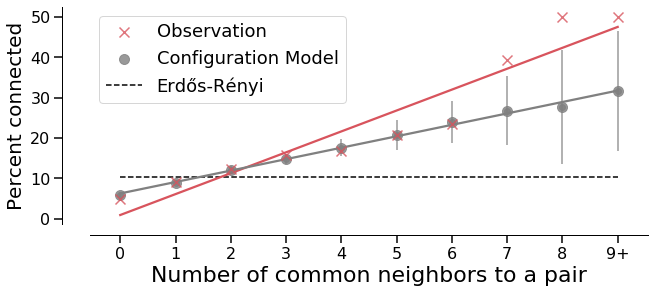

In [13]:
E, N = len(g_th100.edges), len(g_th100.nodes)
ER_p_null = (1 - E / (N*(N-1)))**2

plot_cnr(obs_cnr_stats, cfg_cnr_stats, cfg_cnr_stats_std, ER_p_null, figsize=(10,4), fname="th100/th100_cnr")

In [14]:
# Pearson r^2 and p-value
pearson_r2(np.arange(10), obs_cnr_stats["undir_perc"])

(0.9064855711044748, 2.1742087203426527e-05)

In [15]:
# Pearson r^2 and p-value
pearson_r2(np.arange(10), cfg_cnr_stats["undir_perc"])

(0.9956223405874262, 1.0059765337136046e-10)

## Common Neighbor Rule (Generalized Null Models)

In [16]:
%%time
s=100 # total 100 samples (100 continous samples)
cfg_cnr_samples_GE = continuous_sample_cnr_GE(g_th100, samples=s, niters=int(1e4))


CPU times: user 53.7 s, sys: 56 ms, total: 53.7 s
Wall time: 53.7 s


In [17]:
cfg_cnr_stats_GE, cfg_cnr_stats_std_GE = cnr_mean_std(cfg_cnr_samples_GE)

In [18]:
cfg_cnr_stats_GE

,undir_pair,dir_spair,dir_ppair,undir_conn,dir_sconn,dir_pconn,dir_uni_sconn,dir_uni_pconn,dir_bi_sconn,dir_bi_pconn,undir_perc,dir_sperc,dir_pperc
0,2125.42,4880.73,4095.94,125.94,409.55,374.85,394.76,358.52,14.79,16.33,0.059257,0.083912,0.091516
1,1846.73,1060.97,1688.37,164.92,147.57,193.11,139.12,183.85,8.45,9.26,0.089301,0.139118,0.114382
2,1164.15,273.63,437.21,141.71,51.46,54.61,48.12,51.87,3.34,2.74,0.121741,0.187918,0.124934
3,635.70,76.07,89.10,94.53,18.23,12.12,16.81,11.65,1.42,0.47,0.148679,0.239622,0.136196
4,309.03,23.27,15.05,54.31,6.07,1.97,5.59,1.81,0.48,0.16,0.175758,0.265582,0.130530
5,140.55,7.66,2.01,28.93,2.34,0.27,2.07,0.23,0.27,0.04,0.205528,0.298486,0.104833
6,60.51,3.16,0.28,13.89,0.97,0.06,0.83,0.06,0.14,0.00,0.229624,0.288611,0.055000
7,26.30,1.42,0.04,7.02,0.44,0.01,0.38,0.01,0.06,0.00,0.262875,0.225000,0.010000
8,11.23,0.58,0.00,3.15,0.24,0.00,0.21,0.00,0.03,0.00,0.279900,0.205000,0.000000
9,8.38,0.51,0.00,2.60,0.13,0.00,0.11,0.00,0.02,0.00,0.302181,0.115000,0.000000


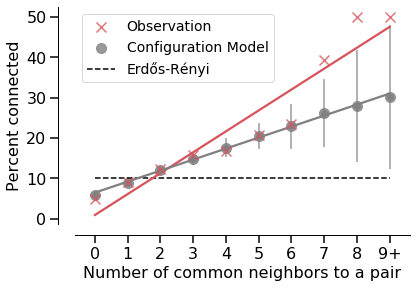

In [19]:
_, two_pr_GE = compute_three_neuron_motif_probabilities_GE(g_th100)
ER_p_null_GE = 1 - 2*two_pr_GE["pr_uni"] - two_pr_GE["pr_bi"]

plot_cnr(obs_cnr_stats, cfg_cnr_stats_GE, cfg_cnr_stats_std_GE, ER_p_null_GE, 
         figsize=(6,4), fontsizes=(16, 16, 16, 14), fname="th100/th100_cnr_GE")

In [20]:
# Pearson r^2 and p-value
pearson_r2(np.arange(10), obs_cnr_stats["undir_perc"])

(0.9064855711044748, 2.1742087203426527e-05)

In [21]:
# Pearson r^2 and p-value
pearson_r2(np.arange(10), cfg_cnr_stats_GE["undir_perc"])

(0.9967763874733134, 2.956583719842556e-11)

## CFG v.s. Generalized ER

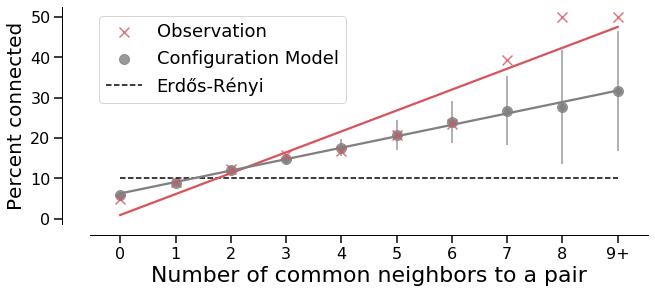

In [24]:
plot_cnr(obs_cnr_stats, cfg_cnr_stats, cfg_cnr_stats_std, ER_p_null_GE, figsize=(10,4), fname="th100/th100_cnr_CGE")